#### Imports

In [3]:
from environments import build_blue_agent, build_red_agent, sample

import ray
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
logger = logging.getLogger(__name__)

/home/garrett/miniconda3/envs/cyborg/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/garrett/miniconda3/envs/cyborg/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/home/garrett/miniconda3/envs/cyborg/lib/python3.8/site-packages/tensorflow/python/fra

#### Verify GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

#### Train Competitive Blue Agent

In [ ]:
tolerance = 3 # number of batches without improvement before ending training
generations = 100

# Create Initial Policies
ray.init(ignore_reinit_error=True, log_to_driver=False)
blue = build_blue_agent()
red = build_red_agent(opponent=True)

blue_scores = []
red_scores = []

print()
print("+---------------------------------+")
print("| Blue Competitive Training Start |")
print("+---------------------------------+")
print()

for g in range(1, generations+1):

    if (g < 10):
        dashes = 14
    elif (g < 100):
        dashes = 15
    else:
        dashes = 16
    print('+'+'-'*dashes+'+')            
    print(f"| Generation {g} |")
    print('+'+'-'*dashes+'+')
    print()

    blue.restore("./policies/blue_competitive_pool/competitive_blue_0/checkpoint_000000")

    b = 0 # b tracks the batches of training completed
    blue_min = float('inf')
    tol = tolerance
    while True:
        b += 1
        result = blue.train()
        blue_score = -result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Blue Score: {blue_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}") 
        if b > 1:
            if (blue_score < blue_min):
                blue_min = blue_score
                tol = tolerance
                checkpoint_path = blue.save(checkpoint_dir=f"./policies/blue_competitive_pool/competitive_blue_{g}")
                path_file = open(f"./policies/blue_competitive_pool/competitive_blue_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
            # when agent is no longer improving, break and save the new competitive agent
            else:
                blue_scores.append(blue_min)
                blue.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_size = g
    pool_file = open("./policies/blue_competitive_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    red.restore("./policies/red_opponent_pool/opponent_red_0/checkpoint_000000")

    b = 0
    red_max = 0
    tol = tolerance
    while True:
        b += 1
        result = red.train()
        red_score = result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Red Score: {red_score:0.2f}    Entropy: {entropy:0.2f}    VF_loss: {vf_loss:0.2f}")
        if b > 1:
            if (red_score > red_max):
                red_max = red_score
                tol = tolerance
                checkpoint_path = red.save(checkpoint_dir=f"./policies/red_opponent_pool/opponent_red_{g}")   
                path_file = open(f"./policies/red_opponent_pool/opponent_red_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
             # when agent is no longer improving, break and save the new best-response agent
            else:
                red_scores.append(red_max)
                red.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_file = open("./policies/red_opponent_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    print(f'Blue Scores so far {["%.2f" % i for i in blue_scores]}')
    print(f'Red Scores so far {["%.2f" % i for i in red_scores]}')
    print()
    
    print(f'-------- Sample Game for Generation {g} --------')
    sample(red, blue, verbose=True, show_policy=True)
    print()

#### Evaluate Blue MinMax Performance

In [ ]:
b_max = [0]*(generations+1) # blue agent maximum scores
b_max_op = [0]*(generations+1) # id of red opponent that got max score
b_best_score = float('inf')
b_best_id = 0

# evaluate existing pool of agents
print('Evaluating Agents...')
# iteration through blue agents
for b in range(generations,0,-1):
    path_file = open(f"./policies/blue_competitive_pool/competitive_blue_{b}/checkpoint_path", "r")
    blue_restore_path = path_file.read()
    path_file.close()
    blue.restore(blue_restore_path)

    # iterate through red agents
    for r in range(generations,0,-1):
        path_file = open(f"./policies/red_opponent_pool/opponent_red_{r}/checkpoint_path", "r")
        red_restore_path = path_file.read()
        path_file.close()
        red.restore(red_restore_path)

        score = sample(red, blue, games=50)
        if score > b_max[b]:
            b_max[b] = score
            b_max_op[b] = r
    
    print(f'Blue Agent {b} allows a maximum of {b_max[b]:0.2f} points, against Red Opponent {b_max_op[b]}.')
    if b_max[b] < b_best_score:
        b_best_score = b_max[b]
        b_best_id = b

print()
print(f'Top performing Blue Agent is generation {b_best_id}')

path_file = open(f"./policies/blue_pool/blue_policy_{b_best_id}/checkpoint_path", "r")
blue_competitive_path = path_file.read()
path_file.close()
path_file = open("./policies/competitive_blue_policy", "w")
path_file.write(blue_competitive_path)
path_file.close()

ray.shutdown()

In [26]:
b_exp = [] # exploitability of each Blue Policy
for b in b_max[1:]:
    b_exp.append(b-b_best_score)
print(b_exp)

[51.5871, 13.8611, 14.3051, 29.585099999999997, 7.553100000000001, 11.2671, 11.391099999999998, 7.9611, 5.681099999999999, 11.5931, 1.1791, 0.5691000000000006, 2.559100000000001, 1.1291000000000002, 4.181100000000001, 1.5671000000000008, 1.1991000000000005, 1.1071, 5.7491, 3.1511000000000013, 4.149100000000001, 0.8951000000000002, 1.3571, 4.0031, 3.4611, 2.2591, 6.5471, 2.5771000000000006, 7.543100000000001, 4.5351, 0.7631000000000006, 0.6151, 0.7871000000000006, 0.9331000000000005, 0.6911000000000005, 0.9831000000000003, 0.4471000000000007, 0.7951000000000006, 1.2711000000000006, 1.5271, 1.2231000000000005, 1.3271000000000006, 2.4971000000000005, 0.41710000000000047, 0.1731000000000007, 0.2871000000000006, 2.0451000000000006, 0.6391, 3.6411, 0.9031000000000002, 0.5991, 0.5271000000000008, 1.2331000000000003, 5.565100000000001, 0.4231000000000007, 0.22310000000000052, 0.7191000000000001, 0.7431000000000001, 0.28310000000000013, 0.6911000000000005, 3.5351, 0.49710000000000054, 0.6871, 0

#### Plot Blue Training Scores

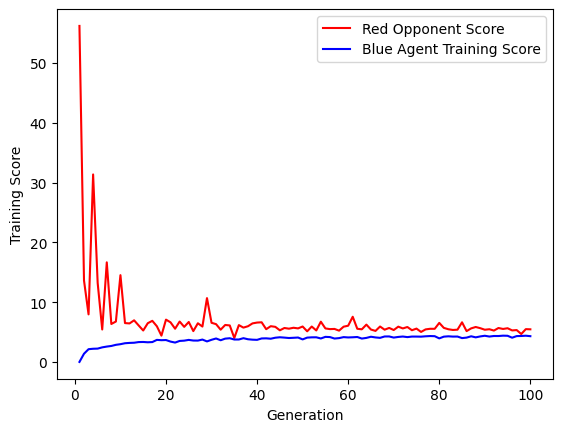

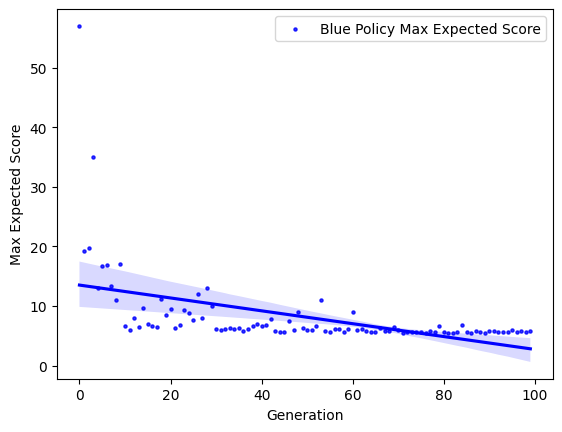

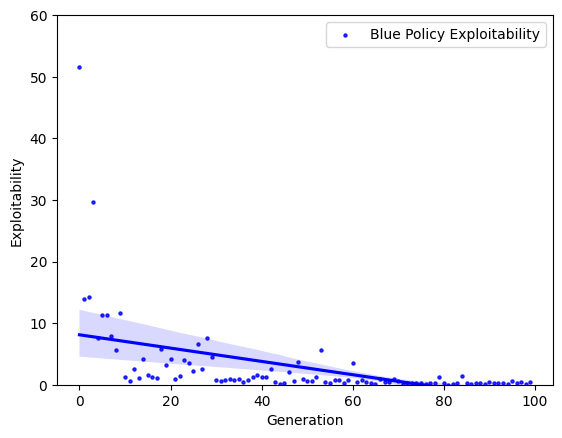

In [33]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot, "Training Score":red_scores, "Blue Scores":blue_scores})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Opponent Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Agent Training Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Max Expected Score":b_max[1:]})
plt.figure()
#sns.regplot(x = "Generation", y = "MinMax Score", data=data_plot, color='red', scatter_kws={'s':5})
sns.regplot(x = "Generation", y = "Max Expected Score", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Max Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Exploitability":b_exp})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Exploitability")
plt.legend()
plt.show()

Dropping first five data points

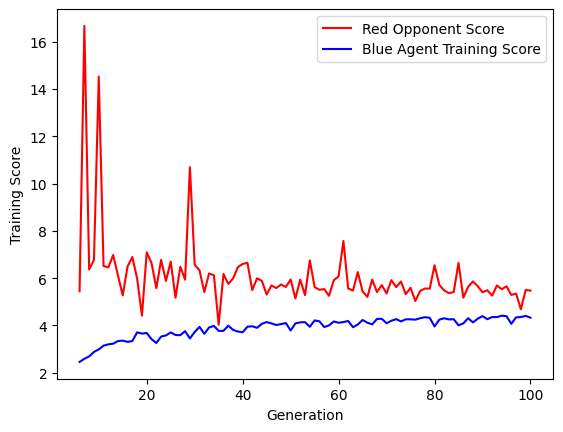

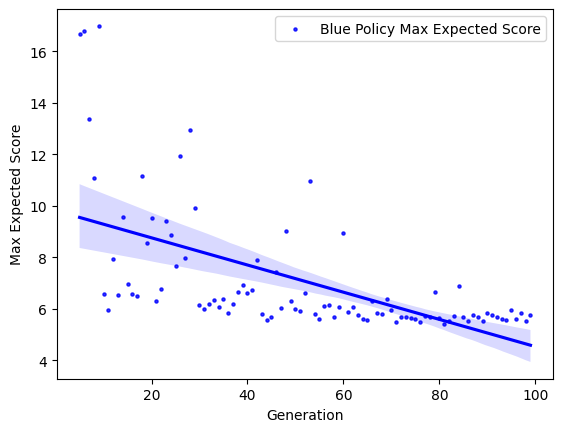

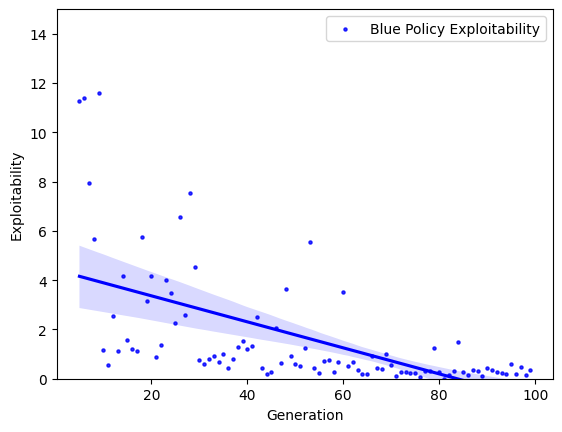

In [34]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Training Score":red_scores[5:], "Blue Scores":blue_scores[5:]})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Opponent Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Agent Training Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Max Expected Score":b_max[6:]})
plt.figure()
sns.regplot(x = "Generation", y = "Max Expected Score", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Max Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Exploitability":b_exp[5:]})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Exploitability")
plt.legend()
plt.show()

#### Train Competitive Red Agent

In [ ]:
tolerance = 3 # number of batches without improvement before ending training
generations = 100

# Create Initial Policies
ray.init(ignore_reinit_error=True, log_to_driver=False)
blue = build_blue_agent(opponent=True)
red = build_red_agent()

blue_scores = []
red_scores = []

print()
print("+--------------------------------+")
print("| Red Competitive Training Start |")
print("+--------------------------------+")
print()

for g in range(1, generations+1):

    if (g < 10):
        dashes = 14
    elif (g < 100):
        dashes = 15
    else:
        dashes = 16
    print('+'+'-'*dashes+'+')            
    print(f"| Generation {g} |")
    print('+'+'-'*dashes+'+')
    print()

    red.restore("./policies/red_competitive_pool/competitive_red_0/checkpoint_000000")

    b = 0
    red_max = 0
    tol = tolerance
    while True:
        b += 1
        result = red.train()
        red_score = result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Red Score: {red_score:0.2f}    Entropy: {entropy:0.2f}    VF_loss: {vf_loss:0.2f}")
        if b > 1:
            if (red_score > red_max):
                red_max = red_score
                tol = tolerance
                checkpoint_path = red.save(checkpoint_dir=f"./policies/red_competitive_pool/competitive_red_{g}")   
                path_file = open(f"./policies/red_competitive_pool/competitive_red_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
             # when agent is no longer improving, break and save the new best-response agent
            else:
                red_scores.append(red_max)
                red.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_size = g
    pool_file = open("./policies/red_competitive_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    blue.restore("./policies/blue_opponent_pool/opponent_blue_0/checkpoint_000000")

    b = 0 # b tracks the batches of training completed
    blue_min = float('inf')
    tol = tolerance
    while True:
        b += 1
        result = blue.train()
        blue_score = -result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Blue Score: {blue_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}") 
        if b > 1:
            if (blue_score < blue_min):
                blue_min = blue_score
                tol = tolerance
                checkpoint_path = blue.save(checkpoint_dir=f"./policies/blue_opponent_pool/opponent_blue_{g}")
                path_file = open(f"./policies/blue_opponent_pool/opponent_blue_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
            # when agent is no longer improving, break and save the new competitive agent
            else:
                blue_scores.append(blue_min)
                blue.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_file = open("./policies/blue_opponent_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    print(f'Blue Scores so far {["%.2f" % i for i in blue_scores]}')
    print(f'Red Scores so far {["%.2f" % i for i in red_scores]}')
    print()
    
    print(f'-------- Sample Game for Generation {g} --------')
    sample(red, blue, verbose=True, show_policy=True)
    print()

#### Evaluate Red MinMax Performance

In [ ]:
r_min = [float('inf')]*(generations+1) # red agent minimum scores
r_min_op = [0]*(generations+1) # id of blue opponent that got max score
r_best_score = 0
r_best_id = 0

# evaluate existing pool of agents
print('Evaluating Agents...')
# iteration through red agents
for r in range(generations,0,-1):
    path_file = open(f"./policies/red_competitive_pool/competitive_red_{r}/checkpoint_path", "r")
    red_restore_path = path_file.read()
    path_file.close()
    red.restore(red_restore_path)

    # iterate through blue opponents
    for b in range(generations+1,1,-1):
        path_file = open(f"./policies/blue_opponent_pool/opponent_blue_{b}/checkpoint_path", "r")
        blue_restore_path = path_file.read()
        path_file.close()
        blue.restore(blue_restore_path)

        score = sample(red, blue, games=50)
        if score < r_min[r]:
            r_min[r] = score
            r_min_op[r] = b
    
    print(f'Red Agent {r} expects a minimum of {r_min[r]:0.2f} points, against Blue Opponent {r_min_op[r]}.')
    if r_min[r] > r_best_score:
        r_best_score = r_min[r]
        r_best_id = r


print()
print(f'Top performing Red Agent is generation {r_best_id}')

path_file = open(f"./policies/red_competitive_pool/competitive_red_{r_best_id}/checkpoint_path", "r")
red_competitive_path = path_file.read()
path_file.close()
path_file = open("./policies/competitive_red_policy", "w")
path_file.write(red_competitive_path)
path_file.close()

ray.shutdown()

In [12]:
r_exp = [] # exploitability of each Red Policy
for r in r_min[1:]:
    r_exp.append(r_best_score-r)
print(r_exp)

[1.8100000000000005, 1.9880000000000004, 1.4680000000000004, 1.3140000000000005, 0.7100000000000004, 1.3560000000000003, 0.8080000000000003, 0.952, 0.7360000000000002, 0.6339999999999999, 0.9020000000000001, 1.0980000000000003, 0.3600000000000003, 0.8679999999999999, 0.3280000000000003, 1.2980000000000005, 0.5380000000000003, 1.1020000000000008, 1.3580000000000005, 0.4440000000000004, 0.7400000000000002, 0.30000000000000027, 1.1800000000000002, 0.9420000000000006, 1.4180000000000006, 0.552, 0.5540000000000003, 0.7880000000000003, 0.4500000000000006, 0.40400000000000036, 1.2000000000000002, 0.6379999999999999, 0.9200000000000004, 0.7439999999999998, 0.7800000000000007, 0.5, 1.5500000000000003, 0.11800000000000033, 0.5099999999999998, 0.4820000000000002, 0.4400000000000004, 0.5820000000000003, 0.3820000000000001, 0.8999999999999999, 0.738, 0.4620000000000002, 0.41800000000000015, 0.2560000000000002, 0.20599999999999996, 0.27600000000000025, 0.2900000000000005, 0.4520000000000004, 0.69600

#### Plot Red Training Scores

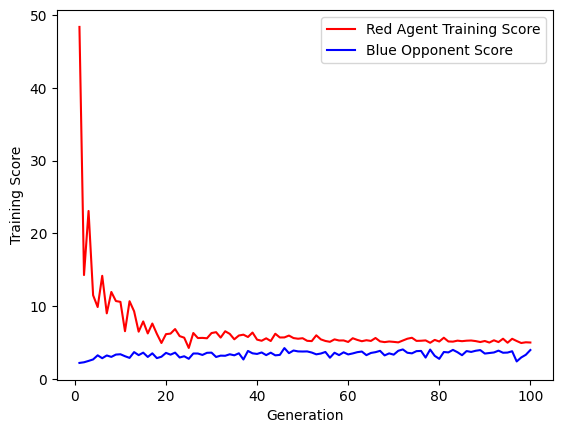

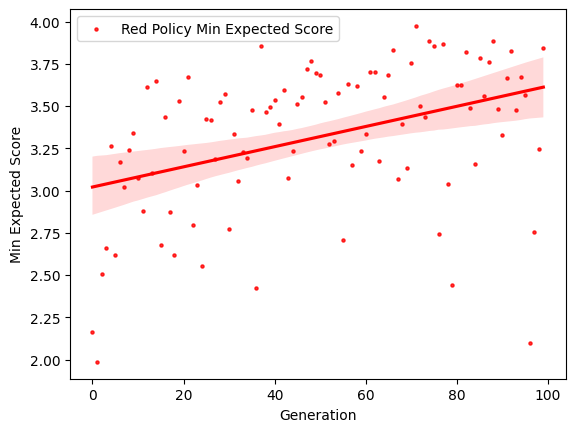

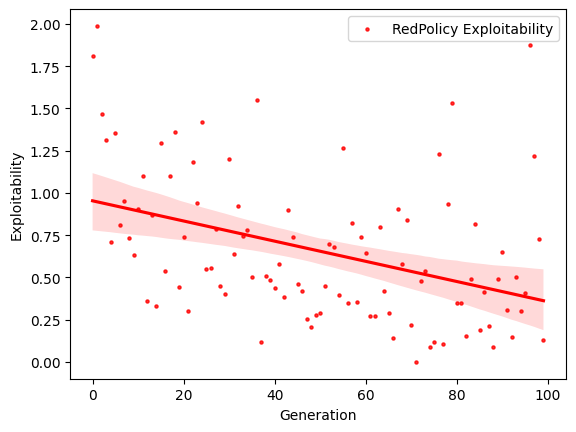

In [13]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot, "Training Score":red_scores, "Blue Scores":blue_scores})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Agent Training Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Opponent Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Min Expected Score":r_min[1:]})
plt.figure()
sns.regplot(x = "Generation", y = "Min Expected Score", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Min Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Exploitability":r_exp})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='red', scatter_kws={'s':5}, label="RedPolicy Exploitability")
plt.legend()
plt.ylim(0, 15)
plt.show()

Dropping first five data points

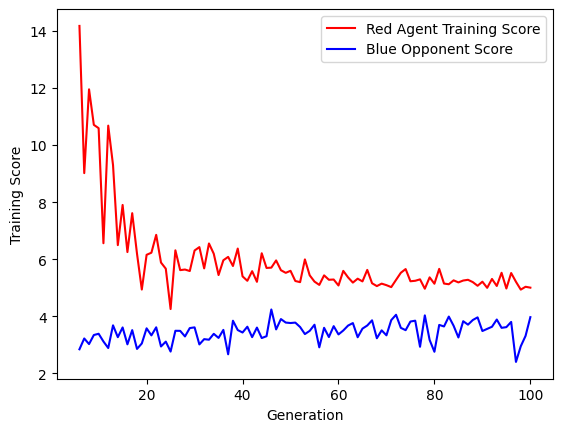

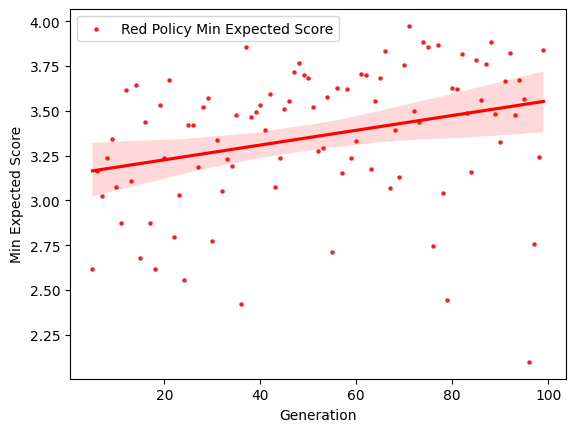

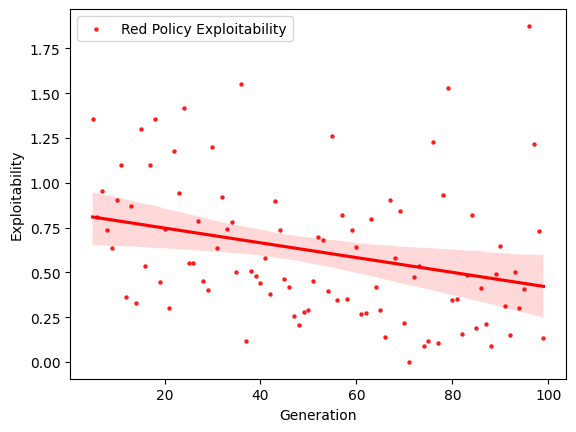

In [14]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Training Score":red_scores[5:], "Blue Scores":blue_scores[5:]})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Agent Training Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Opponent Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Min Expected Score":r_min[6:]})
plt.figure()
sns.regplot(x = "Generation", y = "Min Expected Score", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Min Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Exploitability":r_exp[5:]})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Exploitability")
plt.legend()
plt.show()